Note: must turn off radar in settings before recording

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

#imports + file upload
#print("need to prune imports")
#h+=1

%tensorflow_version 2.x

import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization

import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image

assert len(tf.config.list_physical_devices('GPU')) > 0

from google.colab import files
from skimage.color import rgb2gray
from collections import Counter
from random import shuffle
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt 

import statistics

#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#data processing

#next steps: use GAN to debias dataset (MIT 6.S191 lec 4, lab 2)

def data_processing(start_val,num_files):
  
  s_turn_l = []
  s_turn_r = []
  m_turn_l = []
  m_turn_r = []
  adj_turn_l = []
  adj_turn_r = []
  no_turn = []
  reverse = []
  """
  #try with numpy array
  l_forward = []
  r_forward = []
  l_backward = []
  r_backward = []
  backward = []
  forward = []
  no_key = []

  w =  [1,0,0,0,0,0,0]
  s =  [0,1,0,0,0,0,0]
  wa = [0,0,1,0,0,0,0]
  wd = [0,0,0,1,0,0,0]
  sa = [0,0,0,0,1,0,0]
  sd = [0,0,0,0,0,1,0]
  nk = [0,0,0,0,0,0,1]
  """
  balanced_data = []
  starting_value = start_val
  continue_loop = True
  #start_time = time.time()
  #i=1
  while continue_loop:
    data_file_name = '/content/drive/MyDrive/GTA Driving Data/processed-training_data-{}.npy'.format(starting_value)
    if os.path.isfile(data_file_name) and starting_value < start_val + num_files:
      #print(len(forward))
      processed_data = np.load(data_file_name,allow_pickle=True)
      #time.sleep(1)
      print(starting_value)
      starting_value += 1
      #print(len(processed_data))
      #h+= 1
      #i = 0
      #for i in range(0,len(processed_data)):
      for entry in processed_data:
        y = entry[0][0:3]
        y_ls = round(y[2],2)
        y_ls_flipped = 1-y_ls
        x_raw= entry[1]
        #print(x_raw.shape)
        if (random.randrange(4)==2):
          x_val = random.randrange(155,165)
          y_val = random.randrange(115,125)
          x_resized = cv2.resize(x_raw,(x_val, y_val))
          x = cv2.resize(x_resized,(160, 120))
        else:
          x = cv2.resize(x_raw,(160, 120))
        #plt.imshow(x)
        #plt.show()
        #print(np.shape(x))
        #h+=1
        #x = rgb2gray(entry[1])
        #flipping images
        #y_flipped = [y[0],y[1],1-y_ls]
        x_flipped = cv2.flip(x, 1)
        #flipped_keys_pressed = ""
        #print(y_ls)
        
        if y_ls > 0.875: 
          #very sharp turn, but it doesn't warrant its own array
          s_turn_r.append([x,y_ls])
          #s_turn.append([x_flipped,y_ls_flipped])
        elif y_ls < 0.125:
          #very sharp turn, but it doesn't warrant its own array
          s_turn_l.append([x,y_ls])
          #s_turn.append([x_flipped,y_ls_flipped])  
        elif y_ls > 0.8:
          #sharp turn
          #s_turn.append([x_flipped,y_ls_flipped])
          s_turn_r.append([x,y_ls])
        elif y_ls < 0.2:
          #sharp turn
          #s_turn.append([x_flipped,y_ls_flipped])
          s_turn_l.append([x,y_ls])

        elif y_ls > 0.68:
          #medium turn
          m_turn_r.append([x,y_ls])
          #m_turn.append([x_flipped,y_ls_flipped])
          #i+=1
        elif y_ls < 0.32:
          #medium turn
          m_turn_l.append([x,y_ls])
          #m_turn.append([x_flipped,y_ls_flipped])
          #i+=1
        elif y_ls > 0.63:
          #light turn, doesn't warrant its own array
          adj_turn_r.append([x,y_ls])
          #adj_turn.append([x_flipped,y_ls_flipped])
          #i+=1
        elif y_ls < 0.37:
          #light turn, doesn't warrant its own array
          adj_turn_l.append([x,y_ls])
          #adj_turn.append([x_flipped,y_ls_flipped])
          #i+=1
        elif y_ls > 0.56:
          #light turn, doesn't warrant its own array
          adj_turn_r.append([x,y_ls])
          #adj_turn.append([x_flipped,y_ls_flipped])
        elif y_ls < 0.34:
          #light turn, doesn't warrant its own array
          adj_turn_l.append([x,y_ls])
          #adj_turn.append([x_flipped,y_ls_flipped])
        else:
          no_turn.append([x,y_ls])
          #no_turn.append([x_flipped,y_ls_flipped])
        
        """
        if (y_ls > 0.55 and y[1] > 0.1):
          r_forward.append([x,wd])
        elif (y_ls > 0.55 and y[0] > 0.1):
          r_backward.append([x,sd])
        elif (y_ls < 0.45 and y[1] > 0.1):
          l_forward.append([x,wa])
        elif (y_ls < 0.45 and y[0] > 0.1):
          l_backward.append([x,sa])
        elif y[1] > 0.1:
          forward.append([x,w])
        elif y[0] > 0.1:
          backward.append([x,s])
        else:
          no_key.append([x,nk])
        """
    else:
      if not (starting_value < start_val + num_files):
        continue_loop = False
        break
      else:
        print("file {} not found".format(starting_value))
        starting_value += 1

  #shuffle(no_turn)
  #without shuffling, array adjustment in next step would mean that the training set is full of mirror repeats 
  #we would prefer to have [img12_mirrored,img1] rather than [img1_mirrored, img1]
  #shuffling allows for this

  #balanced_data = s_turn[0:int(len(adj_turn)/3)] + m_turn + adj_turn[0:int(len(m_turn))] + no_turn[0:int(len(adj_turn)/3)]
  #we want agent to make small adjustments, so adj_turn isn't being adjusted
  #we don't want agent to just go straight, so less of no_turn is being added
  

  #balanced_length=min(len(no_turn),len(adj_turn))

  #arr_lengths = [len(adj_turn),len(adj_turn),len(m_turn),len(s_turn)]
  #arr_lengths = [len(l_backward),balanced_length*1,len(r_backward),balanced_length*1.5,len(backward),balanced_length*1.5,balanced_length*1]
  #arr_names = ["no turn (trimmed)","adjustment turn","medium turn", "sharp turn"]
  #arr_names = ["l_backward","l_forward","r_backward", "r_forward","backward","forward","no key"]
  #plt.bar(arr_names,arr_lengths)
  #plt.show()
  
  
  #balanced_data = forward[:len(l_forward)] + backward + r_forward[:len(l_forward)] + l_forward + no_key + r_backward + l_backward #no_turn[0:balanced_length] + adj_turn[0:balanced_length] + m_turn[0:balanced_length] + s_turn[0:balanced_length]# + reverse
  adj_turn_l = adj_turn_l[0:len(adj_turn_r)]
  adj_turn_r = adj_turn_r[0:len(adj_turn_l)]

  balanced_data = no_turn[0:len(adj_turn_l+adj_turn_r)] + adj_turn_l + adj_turn_r + m_turn_l + m_turn_r + s_turn_l + s_turn_r
  
  s_turn_l = []
  s_turn_r = []
  m_turn_l = []
  m_turn_r = []
  adj_turn_l = []
  adj_turn_r = []
  no_turn = []
  #print(i)
  #[0:int(balanced_length*1.5)] + backward + forward[0:int(balanced_length*1.5)]+no_key[0:balanced_length*1]
  shuffle(balanced_data)
  X = []
  Y = []
  """
  for entry in balanced_data:
    entry[0] = rgb2gray(entry[0])
    print(np.array(entry[0]).shape)
    #entry[0] = np.expand_dims(rgb2gray(entry[0]), axis=0)

  """

  X , Y = zip(*balanced_data)

  print("done! have {} test cases".format(len(balanced_data)))
  #print("time to run time: {}".format(time.time()-start_time))
  balanced_data = []

  #X_train_3dim = tf.convert_to_tensor(X)
  #print(X_train_3dim.shape)
  #h+= 1
  #new_shape = list(X_train_3dim.shape) + [1]
  #X_train = tf.reshape(X_train_3dim,new_shape)

  #Y_train_3dim = tf.convert_to_tensor(Y)
  #print(Y_train_3dim.shape)
  #new_shape = list(Y_train_3dim.shape) + [1]
  #Y_train = tf.reshape(Y_train_3dim,new_shape)
  #Y_train_3dim = tf.transpose(Y_train_3dim,perm = [0,2,1])
  #print(Y_train.shape)
  #return X_train_3dim,Y_train_3dim
  return X,Y
 

In [ ]:
X_train, Y_train = data_processing(219,1)

In [3]:


def build_driving_model():
  resnet = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(120, 160, 3))

  for layer in resnet.layers[:-4]:
      layer.trainable = False
  
  """
  for layer in resnet.layers:
      print(layer, layer.trainable)
  """
  model = Sequential()
  model.add(resnet)
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation='tanh'))
  #model.add(Dropout(0.5))
  model.add(Dense(200, activation='tanh'))
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation='tanh'))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation='tanh'))
  #model.add(Dropout(0.5))
  #model.add(Dense(59, activation='tanh'))
  model.add(Dense(1))
  return model




#set up alexnet


def build_alexnet_model():
  #image_shape = (80,60,1)
  np.random.seed(1000)
  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer
  model = tf.keras.Sequential([
    #tf.keras.layers.InputLayer(input_shape=image_shape),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(5,5),strides=(2,2),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation=tf.nn.relu), 
    #tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.linear)])
  
  return model

def build_alexnet_batchnorm_model():
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),#, input_shape=(120, 160, 1)),
    #keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
  ])

  return model

def nvidia_modified():
  model = Sequential()

  #1st layer
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2),activation='elu'))

  #2nd layer
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))

  #3rd layer
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  
  #4th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))

  #5th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))


  #1st Dense Layer
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))

  #2nd Dense Layer
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))

  #3rd Dense Layer
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))

  #output
  model.add(Dense(3))
  
  #Compile model
  #model.compile(tf.keras.optimizers.Adam(lr=0.001), loss = 'mse', metrics = ['accuracy'])
  return model



def build_cnn_model():
      cnn_model = tf.keras.Sequential([
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 2 to reduce the height and width of
        # the output.
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=2),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        #tf.keras.layers.BatchNormalization(axis=3),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        #tf.keras.layers.BatchNormalization(),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        #tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        #tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        #tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # Output layer. Because control vector is made up of 3 values, 
        # this dense layer is made up of only 3 units
        tf.keras.layers.Dense(3)])
      
      return cnn_model

import keras.backend as K
accepted_diff = 0.03 #65% after 210 epochs with 0.03
#accepted_diff = 0.05 #90% after 210 epochs with 0.05
def linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    #tf.print(y_true)
    #tf.print(y_pred)
    return K.mean(K.cast(diff < accepted_diff, tf.float32))
#accepted_diff = 0.03 #65% after 210 epochs with 0.03
wide_accepted_diff = 0.05 #90% after 210 epochs with 0.05
def wide_linear_regression_equality(y_true, y_pred):
    diff = K.abs(y_true-y_pred)
    #tf.print(y_true)
    #tf.print(y_pred)
    return K.mean(K.cast(diff < wide_accepted_diff, tf.float32))

In [ ]:
print(5e-3)


0.005


try weight regularization + image flipping
try to have intermediate size changes


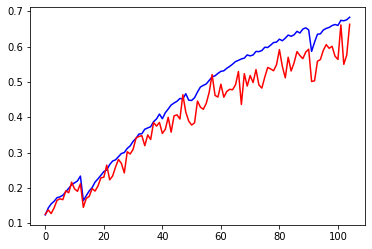

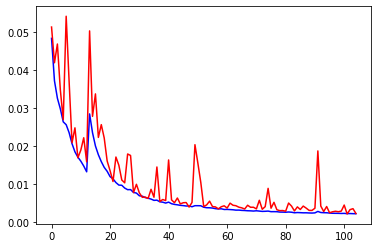

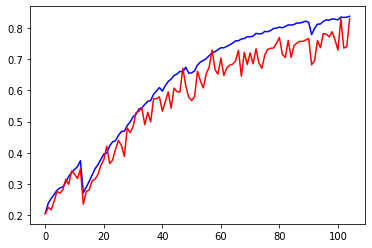

----- --------STARTING EPOCH 106-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 17s 64ms/step - loss: 0.0019 - linear_regression_equality: 0.6706 - wide_linear_regression_equality: 0.8453 - val_loss: 0.0016 - val_linear_regression_equality: 0.7411 - val_wide_linear_regression_equality: 0.8656
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 57ms/step - loss: 0.0020 - linear_regression_equality: 0.6681 - wide_linear_regression_equality: 0.8341 - val_loss: 0.0028 - val_linear_regression_equality: 0.4883 - val_wide_linear_regression_equality: 0.7251
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 10s 58ms/step - loss: 0.0018 - linear_regression_equality: 0.7042 - wide_linear_regression_equalit

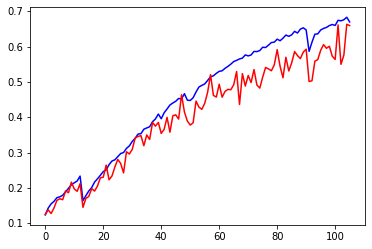

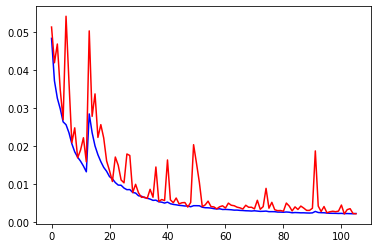

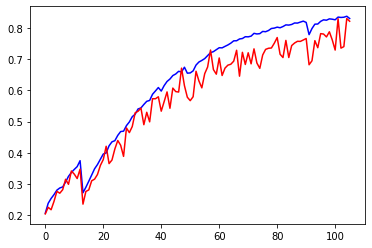

----- --------STARTING EPOCH 107-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 58ms/step - loss: 0.0019 - linear_regression_equality: 0.6812 - wide_linear_regression_equality: 0.8442 - val_loss: 0.0017 - val_linear_regression_equality: 0.7162 - val_wide_linear_regression_equality: 0.8475
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 58ms/step - loss: 0.0020 - linear_regression_equality: 0.6660 - wide_linear_regression_equality: 0.8356 - val_loss: 0.0032 - val_linear_regression_equality: 0.4138 - val_wide_linear_regression_equality: 0.6731
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 10s 60ms/step - loss: 0.0019 - linear_regression_equality: 0.6923 - wide_linear_regression_equalit

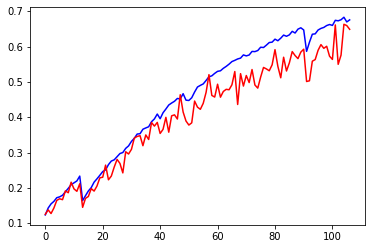

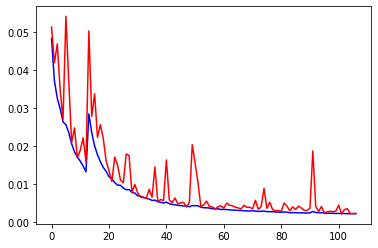

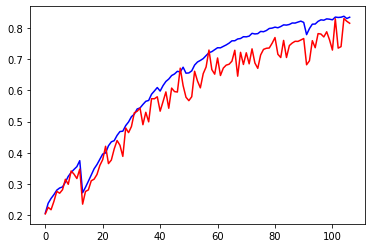

----- --------STARTING EPOCH 108-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 58ms/step - loss: 0.0018 - linear_regression_equality: 0.6828 - wide_linear_regression_equality: 0.8470 - val_loss: 0.0014 - val_linear_regression_equality: 0.7493 - val_wide_linear_regression_equality: 0.8847
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0021 - linear_regression_equality: 0.6703 - wide_linear_regression_equality: 0.8379 - val_loss: 0.0018 - val_linear_regression_equality: 0.7414 - val_wide_linear_regression_equality: 0.8553
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.7160 - wide_linear_regression_equalit

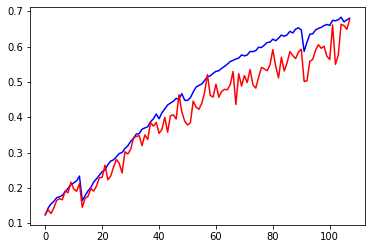

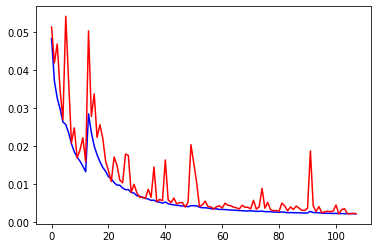

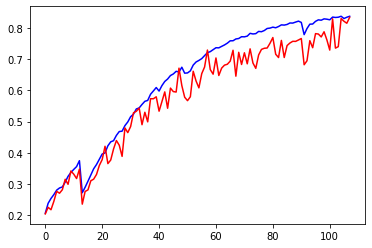

----- --------STARTING EPOCH 109-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.6875 - wide_linear_regression_equality: 0.8497 - val_loss: 0.0018 - val_linear_regression_equality: 0.7277 - val_wide_linear_regression_equality: 0.8527
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6651 - wide_linear_regression_equality: 0.8401 - val_loss: 0.0020 - val_linear_regression_equality: 0.7224 - val_wide_linear_regression_equality: 0.8527
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 10s 60ms/step - loss: 0.0018 - linear_regression_equality: 0.7160 - wide_linear_regression_equalit

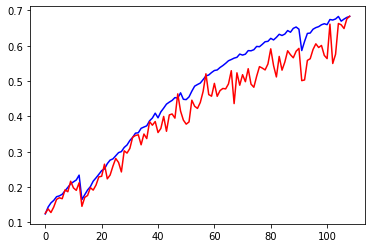

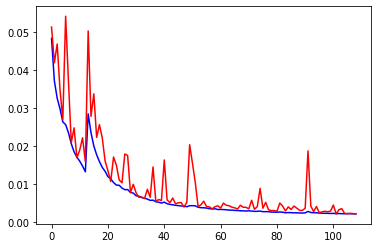

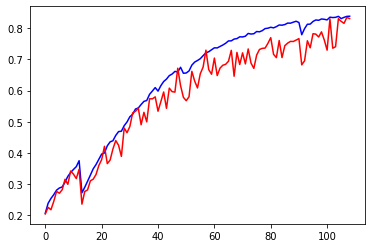

----- --------STARTING EPOCH 110-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.6844 - wide_linear_regression_equality: 0.8446 - val_loss: 0.0017 - val_linear_regression_equality: 0.7470 - val_wide_linear_regression_equality: 0.8598
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6803 - wide_linear_regression_equality: 0.8414 - val_loss: 0.0021 - val_linear_regression_equality: 0.7098 - val_wide_linear_regression_equality: 0.8392
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7276 - wide_linear_regression_equalit

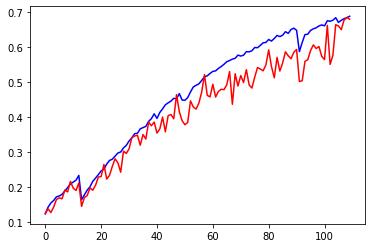

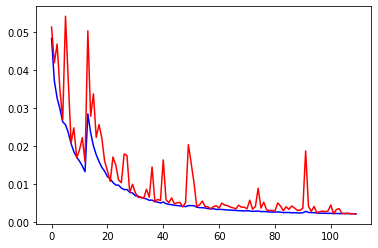

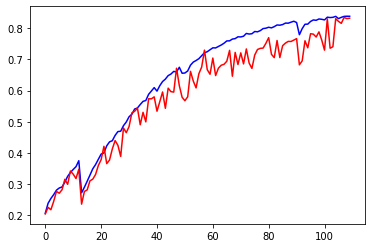

----- --------STARTING EPOCH 111-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.6959 - wide_linear_regression_equality: 0.8517 - val_loss: 0.0014 - val_linear_regression_equality: 0.7524 - val_wide_linear_regression_equality: 0.8747
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 60ms/step - loss: 0.0020 - linear_regression_equality: 0.6758 - wide_linear_regression_equality: 0.8416 - val_loss: 0.0022 - val_linear_regression_equality: 0.6099 - val_wide_linear_regression_equality: 0.8155
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 64ms/step - loss: 0.0017 - linear_regression_equality: 0.7227 - wide_linear_regression_equalit

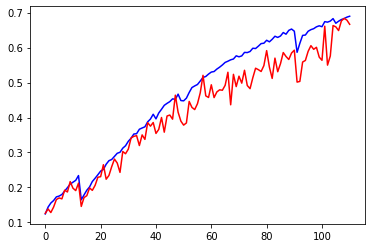

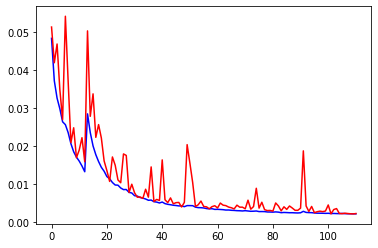

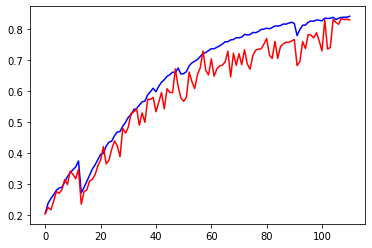

----- --------STARTING EPOCH 112-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0018 - linear_regression_equality: 0.6953 - wide_linear_regression_equality: 0.8521 - val_loss: 0.0019 - val_linear_regression_equality: 0.7278 - val_wide_linear_regression_equality: 0.8433
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6849 - wide_linear_regression_equality: 0.8449 - val_loss: 0.0021 - val_linear_regression_equality: 0.7273 - val_wide_linear_regression_equality: 0.8439
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 63ms/step - loss: 0.0017 - linear_regression_equality: 0.7199 - wide_linear_regression_equalit

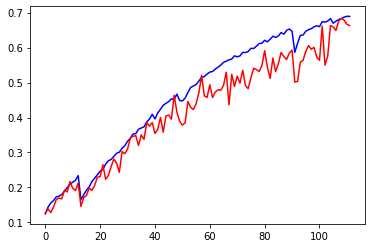

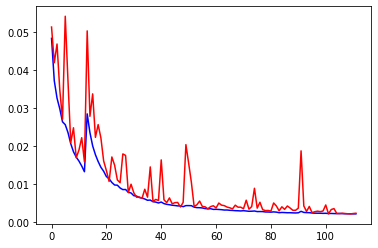

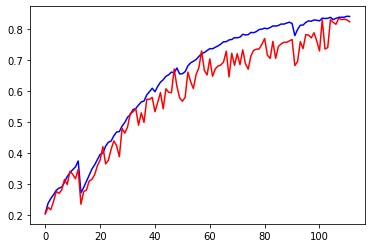

----- --------STARTING EPOCH 113-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0018 - linear_regression_equality: 0.7015 - wide_linear_regression_equality: 0.8533 - val_loss: 0.0017 - val_linear_regression_equality: 0.7339 - val_wide_linear_regression_equality: 0.8609
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6912 - wide_linear_regression_equality: 0.8534 - val_loss: 0.0017 - val_linear_regression_equality: 0.7355 - val_wide_linear_regression_equality: 0.8625
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7350 - wide_linear_regression_equalit

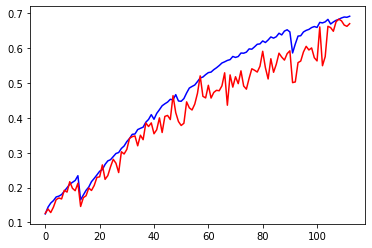

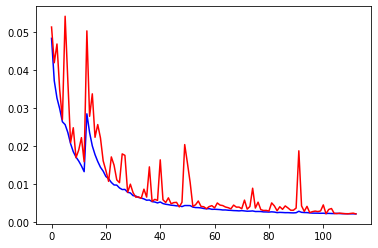

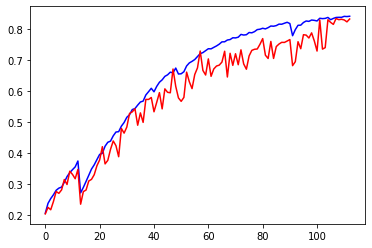

----- --------STARTING EPOCH 114-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0017 - linear_regression_equality: 0.7045 - wide_linear_regression_equality: 0.8560 - val_loss: 0.0017 - val_linear_regression_equality: 0.7360 - val_wide_linear_regression_equality: 0.8749
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6838 - wide_linear_regression_equality: 0.8462 - val_loss: 0.0023 - val_linear_regression_equality: 0.6161 - val_wide_linear_regression_equality: 0.8163
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 64ms/step - loss: 0.0018 - linear_regression_equality: 0.7123 - wide_linear_regression_equalit

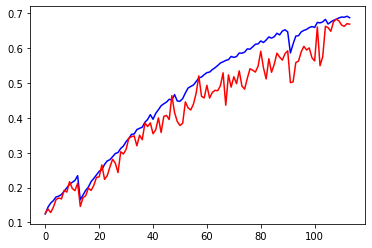

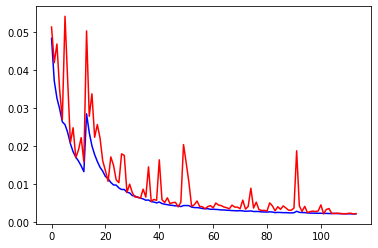

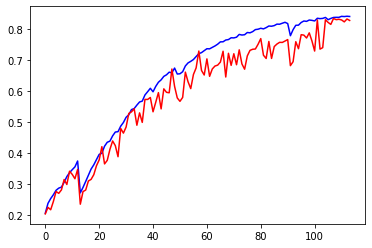

----- --------STARTING EPOCH 115-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7009 - wide_linear_regression_equality: 0.8547 - val_loss: 0.0017 - val_linear_regression_equality: 0.7443 - val_wide_linear_regression_equality: 0.8682
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6925 - wide_linear_regression_equality: 0.8458 - val_loss: 0.0034 - val_linear_regression_equality: 0.3655 - val_wide_linear_regression_equality: 0.6410
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 62ms/step - loss: 0.0019 - linear_regression_equality: 0.6981 - wide_linear_regression_equalit

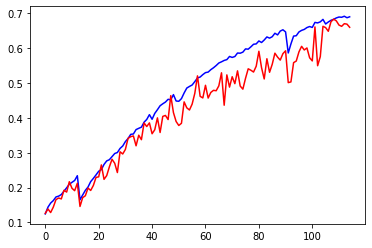

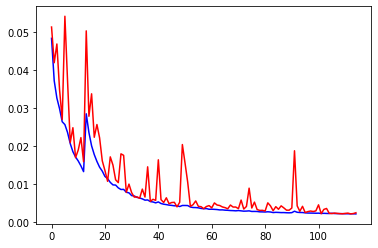

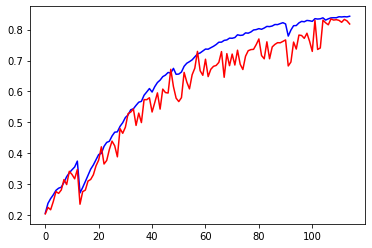

----- --------STARTING EPOCH 116-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 60ms/step - loss: 0.0018 - linear_regression_equality: 0.7064 - wide_linear_regression_equality: 0.8553 - val_loss: 0.0017 - val_linear_regression_equality: 0.7445 - val_wide_linear_regression_equality: 0.8702
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0020 - linear_regression_equality: 0.6801 - wide_linear_regression_equality: 0.8409 - val_loss: 0.0018 - val_linear_regression_equality: 0.7207 - val_wide_linear_regression_equality: 0.8509
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7200 - wide_linear_regression_equalit

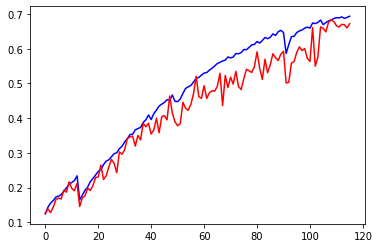

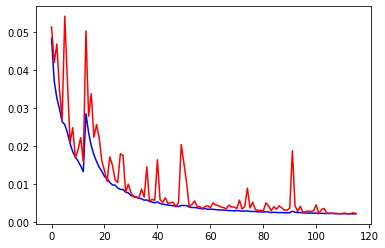

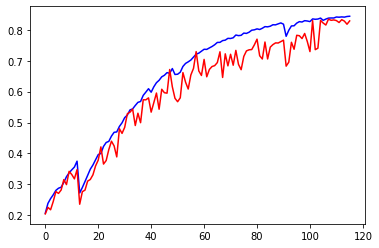

----- --------STARTING EPOCH 117-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7046 - wide_linear_regression_equality: 0.8508 - val_loss: 0.0015 - val_linear_regression_equality: 0.7577 - val_wide_linear_regression_equality: 0.8597
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 62ms/step - loss: 0.0019 - linear_regression_equality: 0.6948 - wide_linear_regression_equality: 0.8503 - val_loss: 0.0020 - val_linear_regression_equality: 0.7184 - val_wide_linear_regression_equality: 0.8562
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 64ms/step - loss: 0.0017 - linear_regression_equality: 0.7254 - wide_linear_regression_equalit

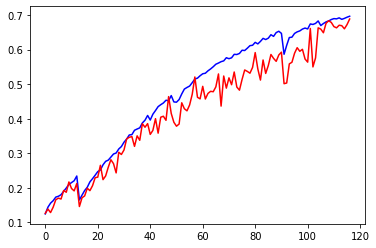

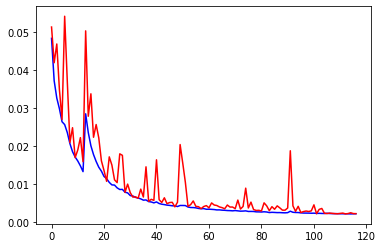

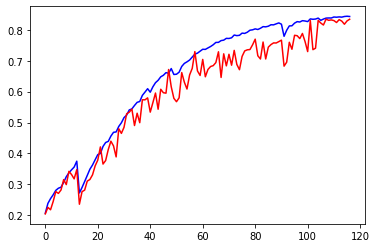

----- --------STARTING EPOCH 118-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7153 - wide_linear_regression_equality: 0.8575 - val_loss: 0.0015 - val_linear_regression_equality: 0.7616 - val_wide_linear_regression_equality: 0.8735
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6966 - wide_linear_regression_equality: 0.8531 - val_loss: 0.0018 - val_linear_regression_equality: 0.7449 - val_wide_linear_regression_equality: 0.8615
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7266 - wide_linear_regression_equalit

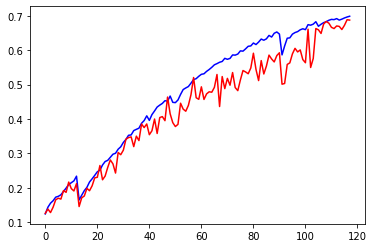

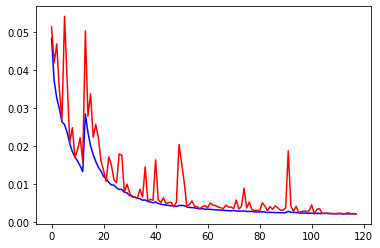

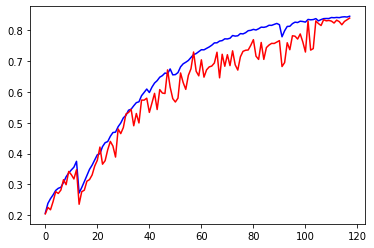

----- --------STARTING EPOCH 119-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7106 - wide_linear_regression_equality: 0.8627 - val_loss: 0.0016 - val_linear_regression_equality: 0.7632 - val_wide_linear_regression_equality: 0.8687
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6867 - wide_linear_regression_equality: 0.8424 - val_loss: 0.0020 - val_linear_regression_equality: 0.6911 - val_wide_linear_regression_equality: 0.8378
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7267 - wide_linear_regression_equalit

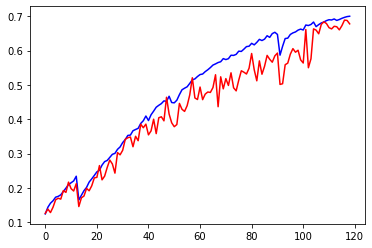

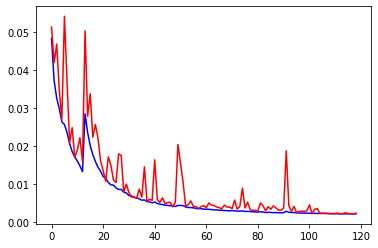

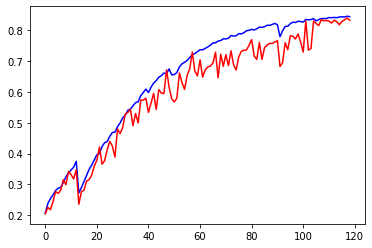

----- --------STARTING EPOCH 120-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7160 - wide_linear_regression_equality: 0.8619 - val_loss: 0.0016 - val_linear_regression_equality: 0.7536 - val_wide_linear_regression_equality: 0.8662
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 62ms/step - loss: 0.0018 - linear_regression_equality: 0.6979 - wide_linear_regression_equality: 0.8496 - val_loss: 0.0046 - val_linear_regression_equality: 0.2697 - val_wide_linear_regression_equality: 0.5237
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0018 - linear_regression_equality: 0.7090 - wide_linear_regression_equalit

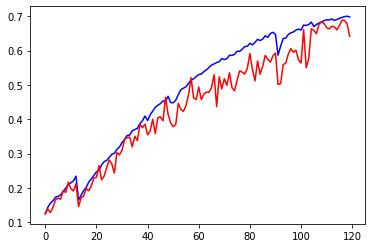

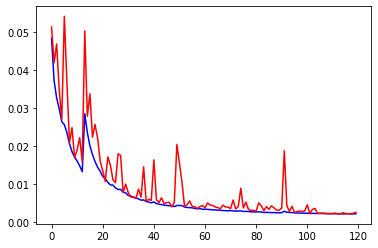

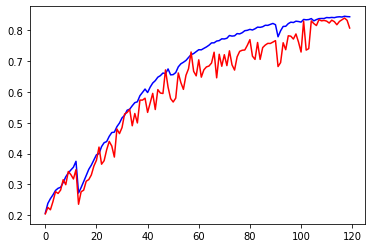

----- --------STARTING EPOCH 121-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7123 - wide_linear_regression_equality: 0.8601 - val_loss: 0.0016 - val_linear_regression_equality: 0.7513 - val_wide_linear_regression_equality: 0.8664
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 62ms/step - loss: 0.0020 - linear_regression_equality: 0.7005 - wide_linear_regression_equality: 0.8503 - val_loss: 0.0018 - val_linear_regression_equality: 0.7502 - val_wide_linear_regression_equality: 0.8649
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7351 - wide_linear_regression_equalit

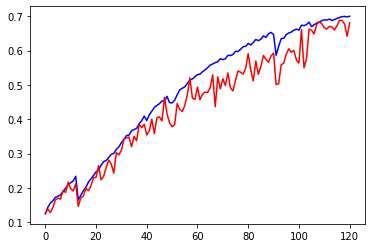

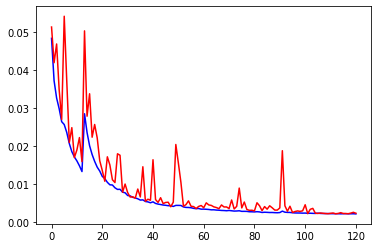

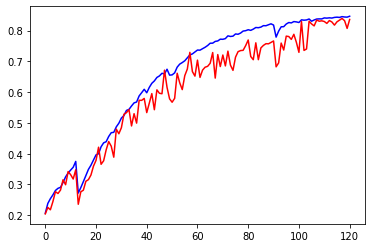

----- --------STARTING EPOCH 122-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7223 - wide_linear_regression_equality: 0.8631 - val_loss: 0.0014 - val_linear_regression_equality: 0.7594 - val_wide_linear_regression_equality: 0.8830
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 12s 61ms/step - loss: 0.0019 - linear_regression_equality: 0.6977 - wide_linear_regression_equality: 0.8550 - val_loss: 0.0016 - val_linear_regression_equality: 0.7646 - val_wide_linear_regression_equality: 0.8827
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 10s 60ms/step - loss: 0.0017 - linear_regression_equality: 0.7358 - wide_linear_regression_equalit

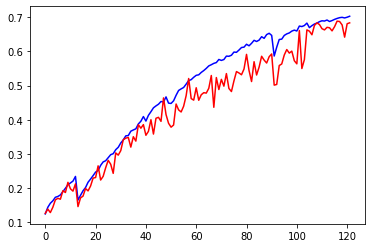

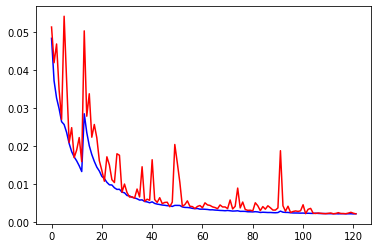

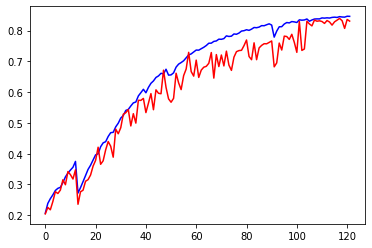

----- --------STARTING EPOCH 123-------------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
done! have 12998 test cases
183/183 [==============================] - 11s 62ms/step - loss: 0.0017 - linear_regression_equality: 0.7158 - wide_linear_regression_equality: 0.8579 - val_loss: 0.0018 - val_linear_regression_equality: 0.7567 - val_wide_linear_regression_equality: 0.8628
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done! have 14295 test cases
202/202 [==============================] - 13s 62ms/step - loss: 0.0019 - linear_regression_equality: 0.7012 - wide_linear_regression_equality: 0.8530 - val_loss: 0.0016 - val_linear_regression_equality: 0.7582 - val_wide_linear_regression_equality: 0.8696
40
file 41 not found
42
43
44
45
46
47
48
49
50
51
52
53
file 54 not found
file 55 not found
56
57
58
59
done! have 12319 test cases
174/174 [==============================] - 11s 61ms/step - loss: 0.0017 - linear_regression_equality: 0.7356 - wide_linear_regression_equalit

In [ ]:
print("try weight regularization + image flipping")
print("try to have intermediate size changes")

#x = np.random.rand(2,160,120,1)
#X = tf.convert_to_tensor(x)

# Initialize the model by passing some data through
#predictions = cnn_model.predict(X_train_0)
#print(predictions)
#print(predictions.shape)
# Print the summary of the layers in the model.
#print(cnn_model.summary())

#load cnn model, load arrays
test_acc   = []
test_loss  = []
train_acc  = []
train_loss = []
wide_train_acc = []
wide_test_acc = []
epoch_to_load = int(input("which epoch to load?"))
if epoch_to_load > 0:
  cnn_model = build_driving_model()
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=2e-3,
      decay_steps=10000,
      decay_rate=0.95)
  optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

  cnn_model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality,wide_linear_regression_equality])
  file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(epoch_to_load)
  cnn_model.load_weights(file_name).expect_partial()

  graph_data = np.load('/content/drive/MyDrive/GTA Driving Data/progress data/resnet_graph_data.npy',allow_pickle=True)
  #[train_acc,test_acc,train_loss,test_loss]
  train_acc = graph_data[0][0:epoch_to_load].tolist()
  test_acc = graph_data[1][0:epoch_to_load].tolist()
  train_loss = graph_data[2][0:epoch_to_load].tolist()
  test_loss = graph_data[3][0:epoch_to_load].tolist()
  wide_train_acc = graph_data[4][0:epoch_to_load].tolist()
  wide_test_acc = graph_data[5][0:epoch_to_load].tolist()
  
  f1 = plt.figure()
  f2 = plt.figure()
  f3 = plt.figure()
  ax1 = f1.add_subplot(111)

  ax1.plot(train_acc, "-b",label = "train accuracy")
  ax1.plot(test_acc, "-r",label = "test accuracy")
  ax2 = f2.add_subplot(111)
  ax2.plot(train_loss, "-b",label = "train loss")
  ax2.plot(test_loss, "-r",label = "test loss")

  ax3 = f3.add_subplot(111)
  ax3.plot(wide_train_acc, "-b",label = "train accuracy (wide)")
  ax3.plot(wide_test_acc, "-r",label = "test accuracy (wide)")


  plt.show()

else:
  cnn_model = build_driving_model()
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1.2e-2,
    decay_steps=10000,
    decay_rate=0.95)
  optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
  #optimizer = keras.optimizers.Adam(learning_rate=5e-3)
  cnn_model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality,wide_linear_regression_equality])#metrics=['accuracy'])


BATCH_SIZE = 64
EPOCHS = 150

start_val = 0
num_files_to_retrieve = 20
num_files_to_test = 233

for epoch in range(epoch_to_load+1,EPOCHS+1):
  epoch_test_acc   = []
  epoch_test_loss  = []
  epoch_train_acc  = []
  epoch_train_loss = []
  epoch_wide_train_acc  = []
  epoch_wide_test_acc  = []
  print('----- --------STARTING EPOCH {}-------------'.format(epoch))

  while start_val < num_files_to_test:
    X, Y= data_processing(start_val,num_files_to_retrieve)
    start_val += num_files_to_retrieve
    #num_files = X_train.shape[0]
    #files_in_epoch += num_files
    X_array = np.array(X).reshape(-1,120,160,3)
    """
    for i in X_array:
      plt.imshow(i)
      plt.show()
    """
    Y_array = np.array(Y).reshape(-1,1)
    history = cnn_model.fit(X_array, Y_array, batch_size=BATCH_SIZE, epochs=1,validation_split=0.1)#,callbacks=[cp_callback])
    
    #print(history.history)
    epoch_train_acc.append(history.history['linear_regression_equality'][0])
    epoch_train_loss.append(history.history['loss'][0])
    epoch_test_loss.append(history.history['val_loss'][0])
    epoch_test_acc.append(history.history['val_linear_regression_equality'][0])
    epoch_wide_test_acc.append(history.history['val_wide_linear_regression_equality'][0])
    epoch_wide_train_acc.append(history.history['wide_linear_regression_equality'][0])
  #print(len(epoch_train_loss))
  print("avg train accuracy: {}".format(statistics.mean(epoch_train_acc)))
  print("avg test accuracy: {}".format(statistics.mean(epoch_test_acc)))
  print("avg train accuracy (wide): {}".format(statistics.mean(epoch_train_acc)))
  print("avg test accuracy (wide): {}".format(statistics.mean(epoch_test_acc)))
  train_acc.append(statistics.mean(epoch_train_acc))
  test_acc.append(statistics.mean(epoch_test_acc))
  train_loss.append(statistics.mean(epoch_train_loss))
  test_loss.append(statistics.mean(epoch_test_loss))
  wide_test_acc.append(statistics.mean(epoch_wide_test_acc))
  wide_train_acc.append(statistics.mean(epoch_wide_train_acc))
  #time.sleep(1)
  start_val = 0
  if epoch % 15 == 0:# and epoch != 0:
        print("SAVED")
        file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(epoch)
        cnn_model.save_weights(file_name)
        graph_data = [train_acc,test_acc,train_loss,test_loss,wide_train_acc,wide_test_acc]
        np.save('/content/drive/MyDrive/GTA Driving Data/progress data/resnet_graph_data.npy',graph_data)

  f1 = plt.figure()
  f2 = plt.figure()
  f3 = plt.figure()
  ax1 = f1.add_subplot(111)

  ax1.plot(train_acc, "-b",label = "train accuracy")
  ax1.plot(test_acc, "-r",label = "test accuracy")
  ax2 = f2.add_subplot(111)
  ax2.plot(train_loss, "-b",label = "train loss")
  ax2.plot(test_loss, "-r",label = "test loss")
  ax3 = f3.add_subplot(111)
  ax3.plot(wide_train_acc, "-b",label = "train accuracy (wide)")
  ax3.plot(wide_test_acc, "-r",label = "test accuracy (wide)")

  plt.show()
#NEXT STEP IS TRIMMING # OF FULL TH RUST FORWARD EXAMPLES IN DATASET

In [ ]:
file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/gta_cnn_model_epoch_{}.h5".format(10)
cnn_model.save(file_name)
graph_data = [time_vals,train_accuracy,test_accuracy]
np.save('/content/drive/MyDrive/GTA Driving Data/progress data/graph_data.npy',graph_data)

In [ ]:
model = build_driving_model()
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
#optimizer = keras.optimizers.Adam(learning_rate=5e-3)
#model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss='mse', optimizer=optimizer, metrics=[linear_regression_equality])

In [ ]:
file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/resnet_model_epoch_{}.ckpt".format(30)
model.load_weights(file_name).expect_partial()

X, Y= data_processing(0,10)
X_array = np.array(X).reshape(-1,100,100,3)
Y_array = np.array(Y).reshape(-1,1)
#for i in range(0,len(X_array)):
#print(Y_array[i])
#x_arr = X_array[i].reshape(-1,100,100,3)
#print(np.round(model.predict(x_arr),2))
#print(np.round(model.predict(x_arr),2)[0][0]-Y_array[i])
loss, acc = model.evaluate(X_array, Y_array, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

0
1
2
3
4
5
6
7
8
9
done! have 6514 test cases
204/204 - 4s - loss: 0.0065 - linear_regression_equality: 0.3049
Restored model, accuracy: 30.49%
